<a href="https://colab.research.google.com/github/itberrios/CV_tracking/blob/main/SORT/SORT_inplementation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **SORT**

Simple Online and Real Time Tracking.

This notebook provides an implementation of the [SORT](https://arxiv.org/pdf/1602.00763.pdf) Algorithm. The SORT Algorithm is an online detection based tracking algorithm that follows 3 main steps:
 - Detect
 - Filter
 - Associate  


 Inspired from the this repository: https://github.com/abewley/sort

## Download Data

In [ ]:
!wget https://s3.eu-central-1.amazonaws.com/avg-kitti/raw_data/2011_09_26_drive_0106/2011_09_26_drive_0106_sync.zip

In [6]:
!jar xf 2011_09_26_drive_0106_sync.zip

## Get YOLOv8

In [62]:
!git clone https://github.com/ultralytics/ultralytics
%cd ultralytics
!pip install -r requirements.txt

In [63]:
%cd ..
!pip install ultralytics

In [448]:
!pip install filterpy

## Base Library Import

In [1]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt


%matplotlib inline
plt.rcParams["figure.figsize"] = (20, 10)

In [19]:
# !wget https://raw.githubusercontent.com/itberrios/CV_tracking/main/SORT/sort.py
!wget https://raw.githubusercontent.com/abewley/sort/master/sort.py # OG SORT
from sort import *

--2023-03-02 21:45:47--  https://raw.githubusercontent.com/abewley/sort/master/sort.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11739 (11K) [text/plain]
Saving to: ‘sort.py’

sort.py             100%[===================>]  11.46K  --.-KB/s    in 0s      

2023-03-02 21:45:47 (90.9 MB/s) - ‘sort.py’ saved [11739/11739]



## View Data

In [3]:
import os
from glob import glob

data_path = r"/content/2011_09_26/2011_09_26_drive_0106_sync/image_02/data"
frame_paths = sorted(list(glob(os.path.join(data_path, "*.png"))))

In [4]:
# get test frames
frame_idx = 1

frame_1 = cv2.cvtColor(cv2.imread(frame_paths[frame_idx]), cv2.COLOR_BGR2RGB)
frame_2 = cv2.cvtColor(cv2.imread(frame_paths[frame_idx + 1]), cv2.COLOR_BGR2RGB)

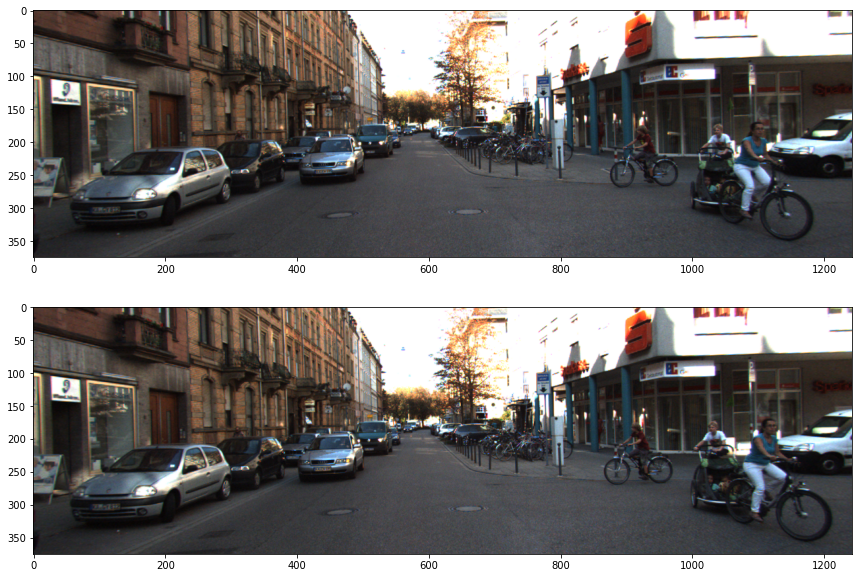

In [5]:
plt.subplot(2, 1, 1)
plt.imshow(frame_1)

plt.subplot(2, 1, 2)
plt.imshow(frame_2)

## Load object Detection model

In [6]:
from ultralytics import YOLO

model = YOLO("yolov8n.pt")

Get Detections on frame

In [14]:
def get_detections(model, frame, conf=0.25):
    """ Obtains object detections from a single frame
        Inputs:
            model - YOLOv8 model object
            frame - RGB frame for detection
        Outputs:
            detections - array containing all detections and classes
                [[x1,y1,x2,y2,cls],...]
        NOTE: can modify this to obtain detections for batches of frames
        """
    # can also process multiple frames at once
    results = model(source=frame, stream=True, conf=conf, nms=True, verbose=False)

    for result in results:
        xyxy = result.boxes.xyxy.numpy()
        cls = result.boxes.cls.numpy()

    return np.hstack((xyxy, np.c_[cls])).astype(int)


Get MSCOCO classes

In [15]:
import yaml

coco_fp = r"/content/ultralytics/ultralytics/datasets/coco.yaml"
with open(coco_fp, "r") as stream:
    try:
        coco_info = yaml.safe_load(stream)
    except yaml.YAMLError as exc:
        print(exc)

# get classes dictionary
classes = coco_info['names']

## Get Colors

In [16]:
def get_color(idx):
    """ Convert an id to a color
    (keep numbers below 255)
    """
    blue = idx*5 % 256
    green = idx*12 %256
    red = idx*23 %256
    return (red, green, blue)

In [24]:
tracker = Sort(max_age=2, min_hits=1, iou_threshold=0.3)

result_frames = []
for fpath in frame_paths:
    frame = cv2.cvtColor(cv2.imread(fpath), cv2.COLOR_BGR2RGB)
    detections = get_detections(model, frame)

    ret = tracker.update(detections)

    # draw track info on frames
    for trk in tracker.tracks:
        pt1 = (trk.box[0], trk.box[1])
        pt2 = (trk.box[2], trk.box[3])

        color = get_color(trk.id)
        # label = str(classes[int(trk.cat)] + '_' + str(trk.id) + '_' + str(trk.hits))
        label = str(str(trk.id) + '_' + str(trk.hits)) # if using OG SORT

        frame = cv2.rectangle(frame, pt1, pt2, color, 2)
        frame = cv2.putText(frame, label, (trk.box[0] + 10, trk.box[1] + 10), 
                    cv2.FONT_HERSHEY_SIMPLEX, 1, color,thickness=2)

    # save results
    result_frames.append(frame)


## Inspect Results

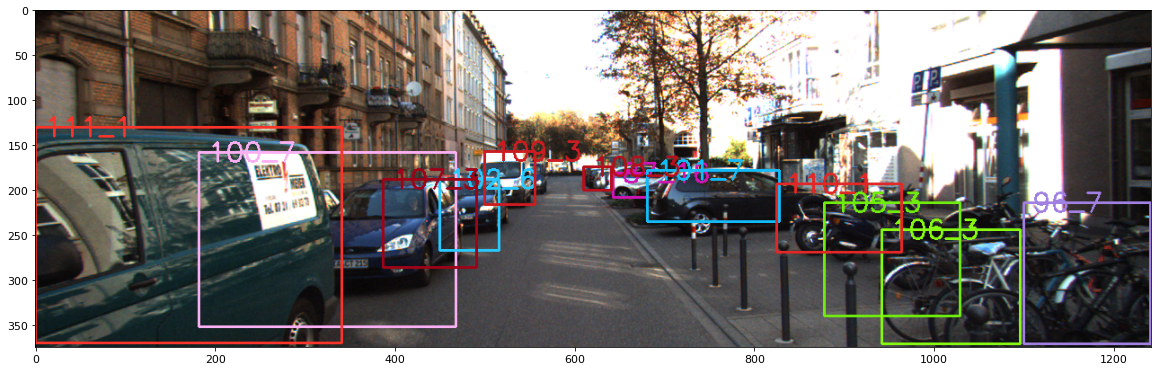

In [26]:
plt.imshow(result_frames[88])

## Make output video

In [27]:
# guestimated form time stamps
fps = 10

out = cv2.VideoWriter('tracked_SORT_OG.mp4',cv2.VideoWriter_fourcc(*'MP4V'), fps, frame.shape[::-1][1:])

for frame in result_frames:
  out.write(frame)

out.release()